In [6]:
import getpass
import os
import re
from typing import Dict, List, TypedDict

import sympy as sp
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0, seed=42)

In [7]:
# Define a sympy-based tool
@tool
def calculate(expression: str) -> str:
    """Calculate an arithmetic expression using sympy.

    Args:
        expression: arithmetic expression as a string (e.g., '3 + 4')

    Returns:
        The evaluated result as a string.
    """
    try:
        expr = sp.sympify(expression)
        evaluated = expr.evalf() if expr.is_number else expr
        return str(evaluated)
    except Exception as e:
        return f"Error: {e}"


# Define a LLM tool
@tool
def llm_tool(expression: str) -> str:
    """Use LLM like yourself to process the input string.
    This is useful for tasks that require reasoning or understanding of the context.
    For example, you can use it to provide explanations.

    Args:
        expression: input string to be processed by LLM

    Returns:
        The processed output as a string.
    """
    response = llm.invoke([SystemMessage(content=expression)])
    return response.content


# Augment the LLM with the sympy tool
tools = [calculate, llm_tool]
tools_by_name = {tool.name: tool for tool in tools}

In [8]:
planer_prompt_system = """
### INSTRUCTIONS ###
You are a math problem solving planner. For the following task, make plans that can solve \
the problem step by step. For each plan, indicate which external tool together with tool input to retrieve \
evidence. You can store the evidence into a variable #E that can be called by later tools \
(Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Calculate[input]: A tool that is used for solving math expressions. It cannot be used with the \
variables. The only variables that can be used are #E1, #E2, ... and they should be \
assigned to the result of the Calculate tool. \
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general world knowledge and \
common sense. Prioritize it when you are confident in solving the problem yourself. Input can be any instruction.

### EXAMPLE ###
# Task: A person has $500. They spend 40% on groceries, 20% on utilities, and 10% on transportation. \
How much money do they have left?

# Solving plan:
Plan: Calculate the total amount spent on groceries, utilities, and transportation.
#E1 = Calculate[0.40 * 500 + 0.20 * 500 + 0.10 * 500]

Plan: Subtract the total amount spent from the initial amount to find the remaining money.
#E2 = Calculate[500 - #E1]
"""

planer_prompt_human = """
### YOUR TASK ###
Describe your plans with rich details. Each Plan should be followed by only one #E.

# Task: {task}
# Solving Plan:
"""

planer_prompt_template = ChatPromptTemplate.from_messages(
    [("system", planer_prompt_system), ("user", planer_prompt_human)]
)

planer_prompt_system_reflection = """
### INSTRUCTIONS ###
You are a math problem solving planner. You can see below the task, the plan and the reflection on this plan. \
You are asked to update the plan based on the reflection. Start the plan over from scratch, \
but you can use the previous plan as a reference. \

Tools can be one of the following:
(1) Calculate[input]: A tool that is used for solving math expressions. It cannot be used with the \
variables. The only variables that can be used are #E1, #E2, ... and they should be \
assigned to the result of the Calculate tool. \
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general world knowledge and \
common sense. Prioritize it when you are confident in solving the problem yourself. Input can be any instruction.

Tools can be one of the following:
(1) Calculate[input]: A tool that is used for solving math expressions using sympy.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general world knowledge and \
common sense. Prioritize it when you are confident in solving the problem yourself. Input can be any instruction. \
However, you should not use LLM to solve math problems.

### EXAMPLE ###
# Task: Peter is 7 years old. His sister is 3 years younger than him. What is the sum of their ages?

# Previous Plan:
Plan: Calulate Peter's sister age
#E1 = Calculate[7 - 3]

# Reflection: The plan is correct, but I need to add a step to calculate the sum of their ages.

# Updated Plan:
Plan: Calculate Peter's sister age
#E1 = Calculate[7 - 3]
Plan: Calculate the sum of Peter's age and his sister's age.
#E2 = Calculate[7 + #E1]
"""

planer_prompt_human_reflection = """
### YOUR TASK ###
Describe your plans with rich details. Each Plan should be followed by only one #E.
# Task: {task}
# Previous Plan: {plan}
# Reflection: {reflection}
# Updated Plan:
"""

planer_prompt_template_reflection = ChatPromptTemplate.from_messages(
    [
        ("system", planer_prompt_system_reflection),
        ("user", planer_prompt_human_reflection),
    ]
)

solver_prompt = """
### INSTRUCTIONS ###
Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

Respond with the answer in a format: "Answer: <value>". Value should be a number without \
any units. If you are not sure about the answer, respond with "I don't know".

### TASK ###
{task}

### PLAN ###
{plan}

### ANSWER ###
"""

In [9]:
class AgentState(TypedDict):
    messages: List[MessagesState]
    task: str
    plan_string: str
    steps: List
    results: Dict
    result: str
    reflection: str


# Planner node
def planner(state: AgentState):
    """Generate a step-by-step plan to solve the problem"""
    regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"

    task = state["task"]

    if "reflection" in state and state["reflection"] is not None:
        # If we have a reflection, we need to update the plan
        prompt = planer_prompt_template_reflection.format_messages(
            task=task,
            plan=state["plan_string"],
            reflection=state["reflection"],
        )

    else:
        # If we don't have a reflection, we need to create a new plan
        prompt = planer_prompt_template.format_messages(task=task)

    response = llm.invoke(prompt)

    # Extract the plan string from the response
    matches = re.findall(regex_pattern, response.content)

    updated_state = {
        "messages": state["messages"] + [response],
        "task": task,
        "plan_string": response.content,
        "steps": matches,
        "results": {},
        "result": None,
        "reflection": None,
    }

    return updated_state


def _get_current_task(state: AgentState):
    if "results" not in state or state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1


# Executor node
def executor(state: AgentState):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    try:
        _, step_name, tool_name, tool_input = state["steps"][_step - 1]
    except IndexError:
        # There was an error in the plan
        return {"messages": state["messages"] + [SystemMessage(content="Error in the plan.")]}

    _results = (state["results"] or {}) if "results" in state else {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool_name == "Calculate":
        result = calculate.invoke(tool_input)
    elif tool_name == "LLM":
        result = llm_tool.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)

    tool_message = ToolMessage(content=f"{tool_input}\nResult: {result}", artifact=result, tool_call_id=step_name)

    updated_state = {
        "messages": state["messages"] + [tool_message],
        "task": state["task"],
        "plan_string": state["plan_string"],
        "steps": state["steps"],
        "results": _results,
        "result": None,
        "reflection": None,
    }

    return updated_state


def solve(state: AgentState):
    plan = ""
    for _plan, step_name, tool_name, tool_input in state["steps"]:
        _results = (state["results"] or {}) if "results" in state else {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool_name}[{tool_input}]"
    prompt = solver_prompt.format(plan=plan, task=state["task"])
    result = llm.invoke(prompt)

    updated_state = {
        "messages": state["messages"] + [result],
        "task": state["task"],
        "plan_string": state["plan_string"],
        "steps": state["steps"],
        "results": state["results"],
        "result": result.content,
        "reflection": None,
    }

    return updated_state


reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a math teacher evaluating a student's problem-solving process.
Provide a detailed critique of the solution path, focusing only on the mathematical correctness of each step.
Do not comment on the formatting, phrasing, style or clarity of the explanation. Only assess the validity of the approach.
If the solution is fully correct with no improvements needed, simply respond with 'END' in all capital letters.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


def reflection_node(state: AgentState) -> AgentState:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage, "tool": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]]
    res = llm.invoke(
        reflection_prompt.format_messages(messages=translated),
        stop=["\n\n###"],
    )

    updated_state = {
        "messages": state["messages"] + [res],
        "task": state["task"],
        "plan_string": state["plan_string"],
        "steps": state["steps"],
        "results": state["results"],
        "result": state["result"],
        "reflection": res.content,
    }

    return updated_state


def _route(state: AgentState):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"


def should_continue(state: AgentState):
    if len([msg for msg in state["messages"] if isinstance(msg, AIMessage)]) > 3:
        # print("Reached the limit of messages")
        return END

    if "END" in state["reflection"]:
        # If the last message is "END", we stop
        # print("Reflection node returned END")
        return END

    return "plan"


graph = StateGraph(AgentState)

graph.add_node("plan", planner)
graph.add_node("tool", executor)
graph.add_node("solve", solve)
graph.add_node("reflect", reflection_node)

graph.add_edge(START, "plan")
graph.add_edge("plan", "tool")
graph.add_conditional_edges("tool", _route)
graph.add_edge("solve", "reflect")
graph.add_conditional_edges("reflect", should_continue)


agent = graph.compile()

In [10]:
# EXAMPLE

task = "Toulouse has twice as many sheep as Charleston. Charleston has 4 times as many sheep as Seattle. How many sheep do Toulouse, Charleston, and Seattle have together if Seattle has 20 sheep?"
# task = 'Lorraine and Colleen are trading stickers for buttons. Each large sticker is worth a large button or three small buttons. A small sticker is worth one small button. A large button is worth three small stickers. Lorraine starts with 30 small stickers and 40 large stickers. She trades 90% of her small stickers for large buttons. She trades 50% of her large stickers for large buttons and trades the rest of them for small buttons. How many buttons does she have by the end?'

messages = [HumanMessage(content=task)]


result = agent.invoke({"task": task, "messages": messages})

# Print full conversation with steps
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Toulouse has twice as many sheep as Charleston. Charleston has 4 times as many sheep as Seattle. How many sheep do Toulouse, Charleston, and Seattle have together if Seattle has 20 sheep?
================================== Ai Message ==================================

# Solving Plan:

Plan: First, we need to determine how many sheep Seattle has. According to the problem, Seattle has 20 sheep. We will store this value for later use.
#E1 = Calculate[20]

Plan: Next, we will calculate how many sheep Charleston has. Since Charleston has 4 times as many sheep as Seattle, we will multiply the number of sheep Seattle has by 4.
#E2 = Calculate[4 * #E1]

Plan: Now, we will find out how many sheep Toulouse has. The problem states that Toulouse has twice as many sheep as Charleston. Therefore, we will multiply the number of sheep Charleston has by 2.
#E3 = Calculate[2 * #E2]

Plan: Finally, we will calculate the to

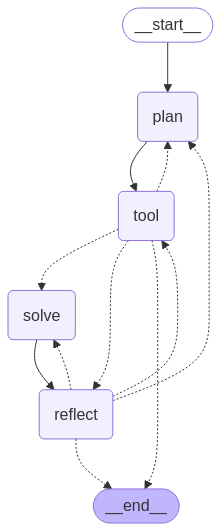

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Calculate metrics

In [7]:
from datasets import load_dataset

# Load the GSM8K dataset
dataset = load_dataset("gsm8k", "main")

# Access the training and test splits
train_dataset = dataset["train"]
test_dataset = dataset["test"]

val_sample = test_dataset.shuffle(seed=42).select(range(100))

/Users/macbook/.pyenv/versions/3.11.10/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import re

import pandas as pd
from tqdm import tqdm


def check_answer(model_answer, true_answer):
    true_answer = true_answer.replace(",", "")

    return str(model_answer) in true_answer


def process_problem(problem):
    # Get the math problem and the correct answer
    math_problem = problem["question"]
    correct_answer = problem["answer"].split("### ")[1]

    human_message = HumanMessage(content=math_problem)

    # Generate the model's response asynchronously
    model_response = agent.invoke({"task": problem, "messages": [human_message]}, {"recursion_limit": 100})
    # Extract the content of the last AI message
    content = model_response["result"]

    # Use regex to parse the numerical answer
    try:
        model_ans = re.search(r"Answer:\s*[^0-9]*([\d]+(?:\.\d+)?)", content).group(1).strip()
        is_correct = check_answer(model_ans, correct_answer)
    except Exception:
        is_correct = False
    return (
        "\n".join(m.pretty_repr() for m in model_response["messages"]),
        is_correct,
        problem["question"],
        problem["answer"],
    )


def bench(val_sample):
    k = 0
    model_answers = []

    # Process all tasks with progress tracking
    for problem in tqdm(val_sample, total=len(val_sample)):
        content, is_correct, problem, answer = process_problem(problem)
        model_answers.append(
            {"Agent answer": content, "is_correct": is_correct, "Problem": problem, "Right Answer": answer}
        )
        if is_correct:
            k += 1
    print(f"Precision: {k / len(val_sample)}")

    return pd.DataFrame(model_answers)


In [9]:
results = bench(val_sample)

100%|██████████| 100/100 [09:24<00:00,  5.65s/it]

Precision: 0.99


In [10]:
# Add a symbol for proper import in Excel
results["Agent answer"] = results["Agent answer"].apply(lambda x: "-" + x)

# Save the results to an Excel file
results.to_excel("results/reflection_agent_bench.xlsx", index=False)